In [1]:
import os
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk

Load Data

In [2]:
def load_data(dir):
    data = []
    for file in os.listdir(dir):
        if file.endswith(".csv"):
            print(os.path.join(dir, file))
            df = pd.read_csv(os.path.join(dir, file),on_bad_lines='skip')
            if not df.empty:
                data.append(df)
    return data


try:
    Group1 = load_data("/mnt/ArtHeart/Data/Group 1")
    Group2 = load_data("/mnt/ArtHeart/Data/Group 2")
    Group3 = load_data("/mnt/ArtHeart/Data/Group 3")
except:
    try:
        Group1 = load_data("Data/Group 1")
        Group2 = load_data("Data/Group 2")
        Group3 = load_data("Data/Group 3")
    except:
        Group1 = load_data("W:\PhD\ArtHeart\Data\Group 1")
        Group2 = load_data("W:\PhD\ArtHeart\Data\Group 2")
        Group3 = load_data("W:\PhD\ArtHeart\Data\Group 3")


Data/Group 1/WRT_WRT_DB:BA:5D:28:F4:C1_2022-08-28 21:43:06.csv
Data/Group 1/WRT_WRT_E1:B8:F8:F2:CE:22_2022-08-28 22:01:02.csv
Data/Group 1/WRT_WRT_D7:DD:AE:B4:E6:35_2022-08-28 21:46:47.csv
Data/Group 1/WRT_WRT_C7:D4:23:10:CC:64_2022-08-28 21:30:36.csv
Data/Group 1/WRT_WRT_EC:BC:BD:73:20:A9_2022-08-28 21:44:43.csv
Data/Group 1/WRT_WRT_F8:8B:C5:5C:D9:5D_2022-08-28 22:32:46.csv
Data/Group 1/WRT_WRT_C7:C3:E6:76:32:D9_2022-08-28 22:27:10.csv
Data/Group 1/WRT_WRT_C8:46:62:32:B0:4F_2022-08-28 22:34:46.csv
Data/Group 1/WRT_WRT_EA:5D:8A:61:72:EE_2022-08-28 22:03:11.csv
Data/Group 1/WRT_WRT_DB:92:4D:E9:1A:1E_2022-08-28 21:50:19.csv
Data/Group 1/WRT_WRT_EE:FA:70:F9:EC:CC_2022-08-28 22:18:49.csv
Data/Group 1/WRT_WRT_E2:D0:DF:09:B7:C4_2022-08-28 21:57:41.csv
Data/Group 1/WRT_WRT_F5:0D:30:BD:11:6F_2022-08-28 22:17:18.csv
Data/Group 1/WRT_WRT_F1:20:19:D6:DA:85_2022-08-28 22:06:27.csv
Data/Group 1/WRT_WRT_EE:59:B1:F9:6A:0F_2022-08-28 21:34:57.csv
Data/Group 1/WRT_WRT_F8:D6:AB:BD:20:53_2022-08-28 21:48

In [3]:
def interpolate_nan(data):
    for i in range(len(data)):
        df = data[i]
        df['UTC'] = df['UTC'].interpolate()
        data[i] = df
    return data


def cut_to_common_length(data):

    # Interpolate NaN values
    data = interpolate_nan(data)

    # Find the shortest dataframe
    shortest_df = min(data, key=lambda x: len(x))

    # Find the first value of UTC in the shortest dataframe that isn't NaN
    first_utc = shortest_df['UTC'].first_valid_index()
    first_utc_value = shortest_df['UTC'][first_utc]

    # Find the length of the dataframe from that point to the end
    length = len(shortest_df.loc[first_utc:])

    # Cut all dataframes to the same length and reset the index
    for i in range(len(data)):
        df = data[i]

        if first_utc_value in df['UTC'].values:
            match_utc_index = df[df['UTC'] == first_utc_value].index[0]
        else:
            match_utc_index = df.iloc[(df['UTC']-first_utc_value).abs().argsort()[:1]].index[0]

        df = df.loc[match_utc_index:].iloc[:length].reset_index(drop=True)
        data[i] = df
    return data




Group1 = cut_to_common_length(Group1)
Group2 = cut_to_common_length(Group2)
Group3 = cut_to_common_length(Group3)
 
sample_rate = 24

/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/pyth

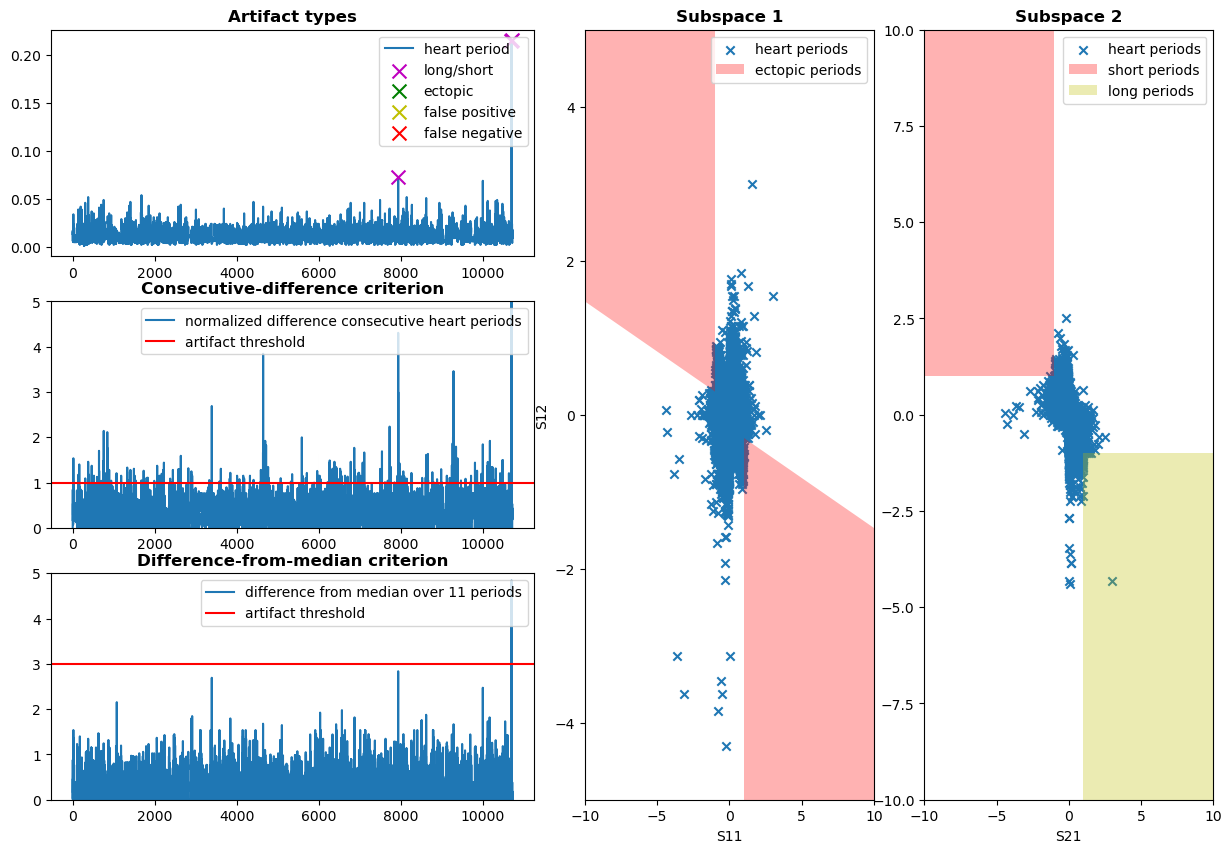

In [4]:
rpeaks_uncorrected  = nk.signal_findpeaks(Group1[0]['DATA'])
artifacts, rpeaks_corrected = nk.signal_fixpeaks(rpeaks_uncorrected, iterative=True, show=True)


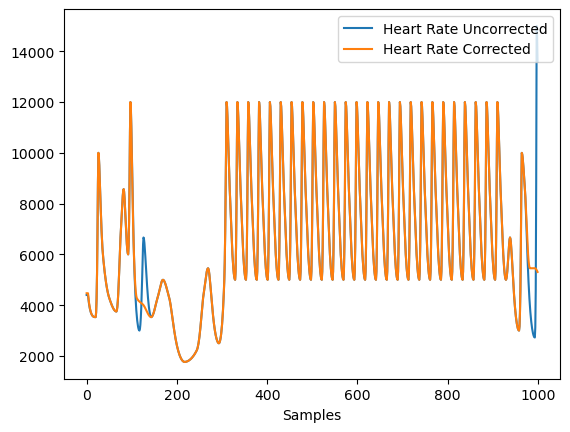

In [5]:
rate_corrected = nk.signal_rate(rpeaks_corrected, desired_length=len(Group1[0]['DATA']))

rate_uncorrected = nk.signal_rate(rpeaks_uncorrected, desired_length=len(Group1[0]['DATA']))

nk.signal_plot(
    [rate_uncorrected[:1000], rate_corrected[:1000]],
    labels=["Heart Rate Uncorrected", "Heart Rate Corrected"]
)

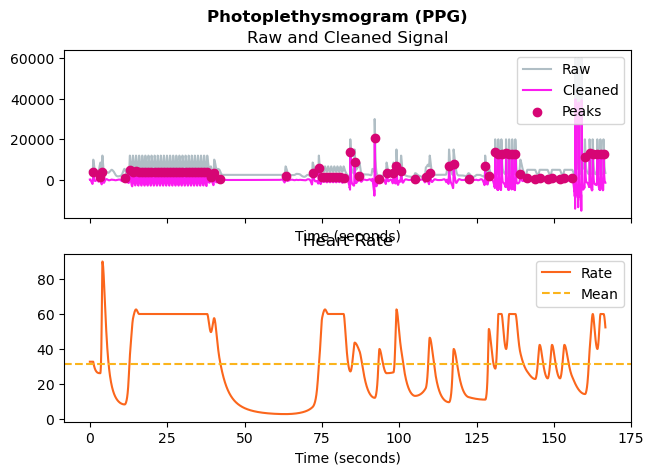

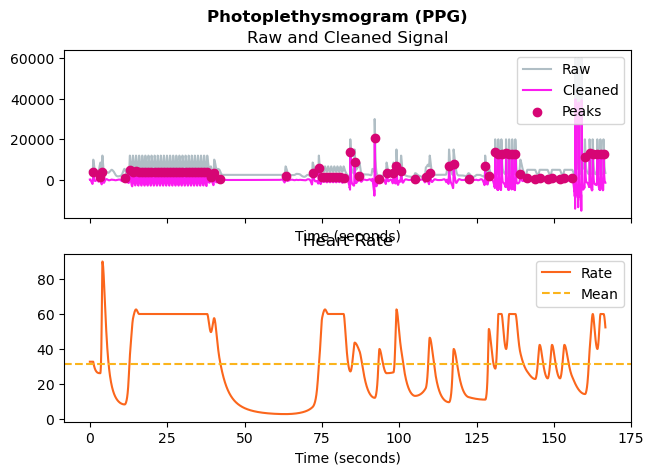

In [6]:
signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals[:4000], sampling_rate=24)

In [7]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=sample_rate)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1   HRV_SDNNI1  \
0      35.014463  1833.002039  2399.68004  663.463384  2197.318681   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0  372.564357  2259.471004  262.319868  2350.030653  3334.842914  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.531479    5.271455      0.56442   0.29547   0.823248    0.686836   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.391429  1.965391  2.503054  0.789049  

[1 rows x 90 columns]


So it looks like the bad sections in the data are affecting the average calculations so now we will cut them out and do the analysis again

In [8]:
def cut_bad_data(raw, windowsize = 100):
    mx = np.max(raw)
    mn = np.min(raw)
    global_range = mx - mn
    
    filtered = []
    
    for i in range(len(raw) // windowsize):
        start = i * windowsize
        end = (i + 1) * windowsize
        sliced = raw[start:end]
        rng = np.max(sliced) - np.min(sliced)
        
        if ((rng >= (0.5 * global_range)) 
            or 
            (np.max(sliced) >= 0.9 * mx) 
            or 
            (np.min(sliced) <= mn + (0.1 * mn))):
            
            for x in sliced:
                filtered.append(np.nan)
        else:
            for x in sliced:
                filtered.append(x)
                
    filtered = np.array(filtered)
    filtered = filtered[~np.isnan(filtered)]
    return filtered

data = Group1[0]['DATA']
data = cut_bad_data(data)

/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/neurokit2/signal/signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/pyth

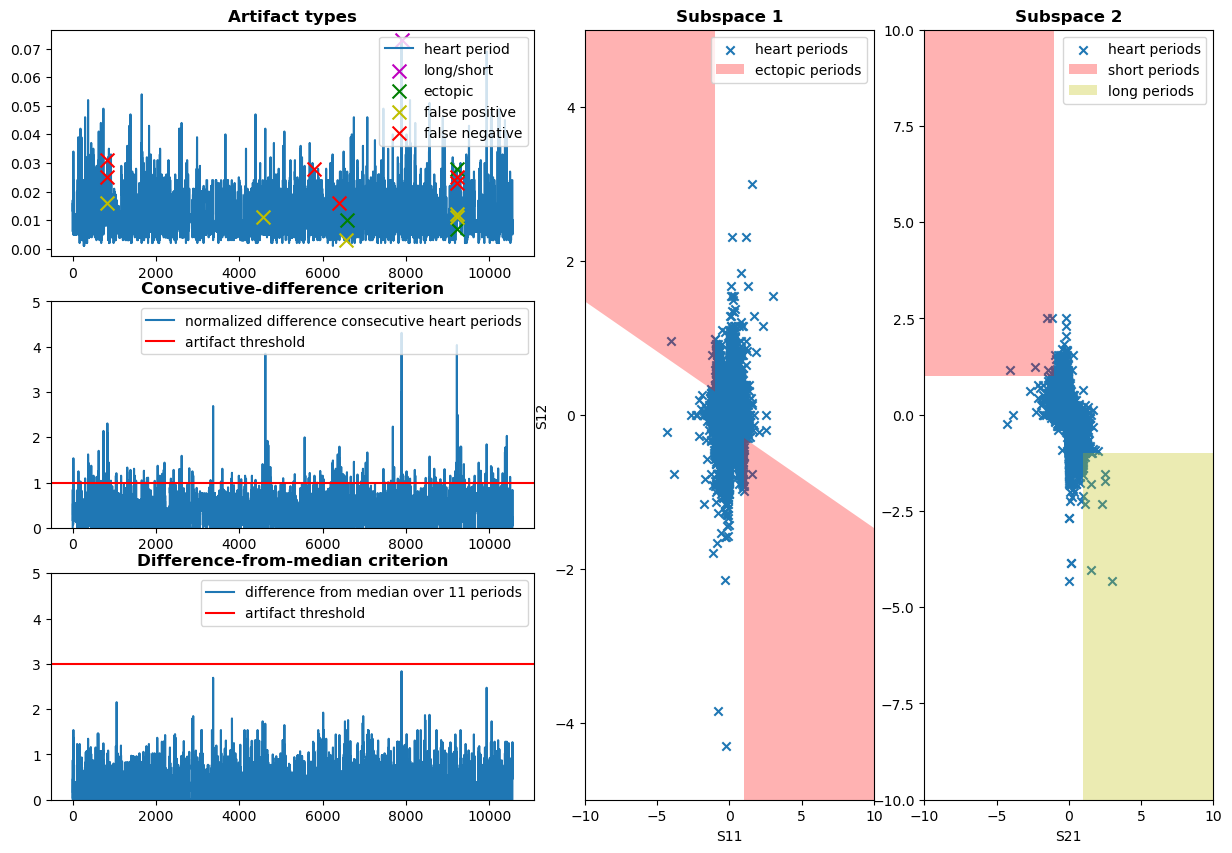

In [9]:
rpeaks_uncorrected  = nk.signal_findpeaks(data)
artifacts, rpeaks_corrected = nk.signal_fixpeaks(rpeaks_uncorrected, iterative=True, show=True)

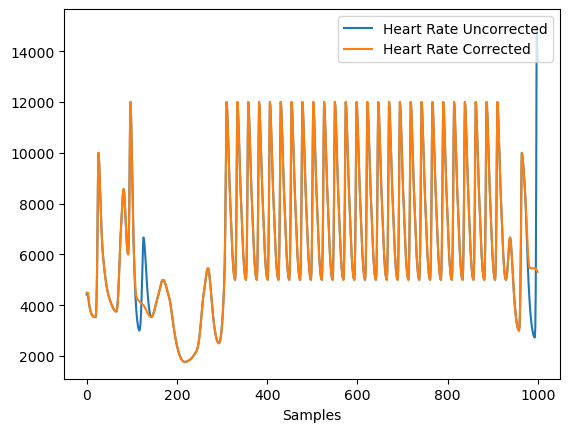

In [10]:
rate_corrected = nk.signal_rate(rpeaks_corrected, desired_length=len(Group1[0]['DATA']))

rate_uncorrected = nk.signal_rate(rpeaks_uncorrected, desired_length=len(Group1[0]['DATA']))

nk.signal_plot(
    [rate_uncorrected[:1000], rate_corrected[:1000]],
    labels=["Heart Rate Uncorrected", "Heart Rate Corrected"]
)

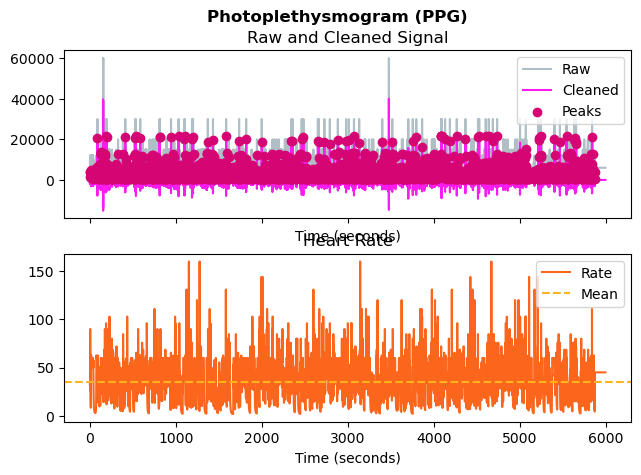

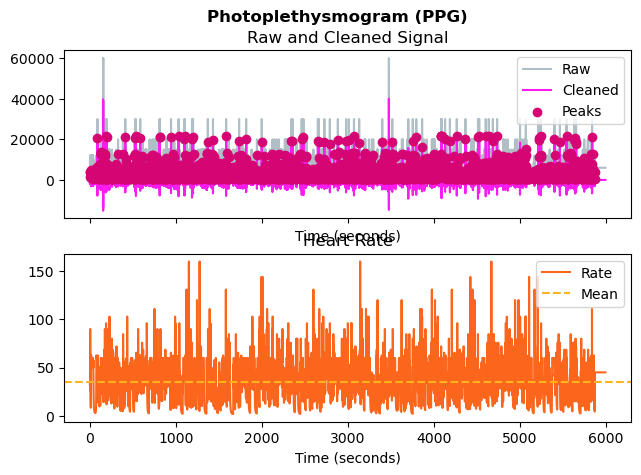

In [11]:
signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals, sampling_rate=24)

In [12]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN  HRV_SDANN1   HRV_SDNNI1  \
0      35.377609  1822.241183  2310.443502   612.79002  2154.495223   

   HRV_SDANN2  HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0  381.052841  2235.27582  278.185592  2286.994476  3187.360155  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.527187    5.256634     0.570462  0.318334   0.821146    0.683984   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.389251  1.957202  2.480685  0.788276  

[1 rows x 90 columns]


Again not much changed. now I will try removing baseline wander, scaling and filtering along with the removal of bad sections 

In [13]:
import heartpy as hp

def remove_baseline_wander(data):
    data = hp.remove_baseline_wander(data, sample_rate=24)
    data = hp.filter_signal(data, cutoff=[0.7, 3.5], sample_rate=24, order=3, filtertype='bandpass')
    return data

data = cut_bad_data(Group1[0]['DATA'])
data = remove_baseline_wander(data)


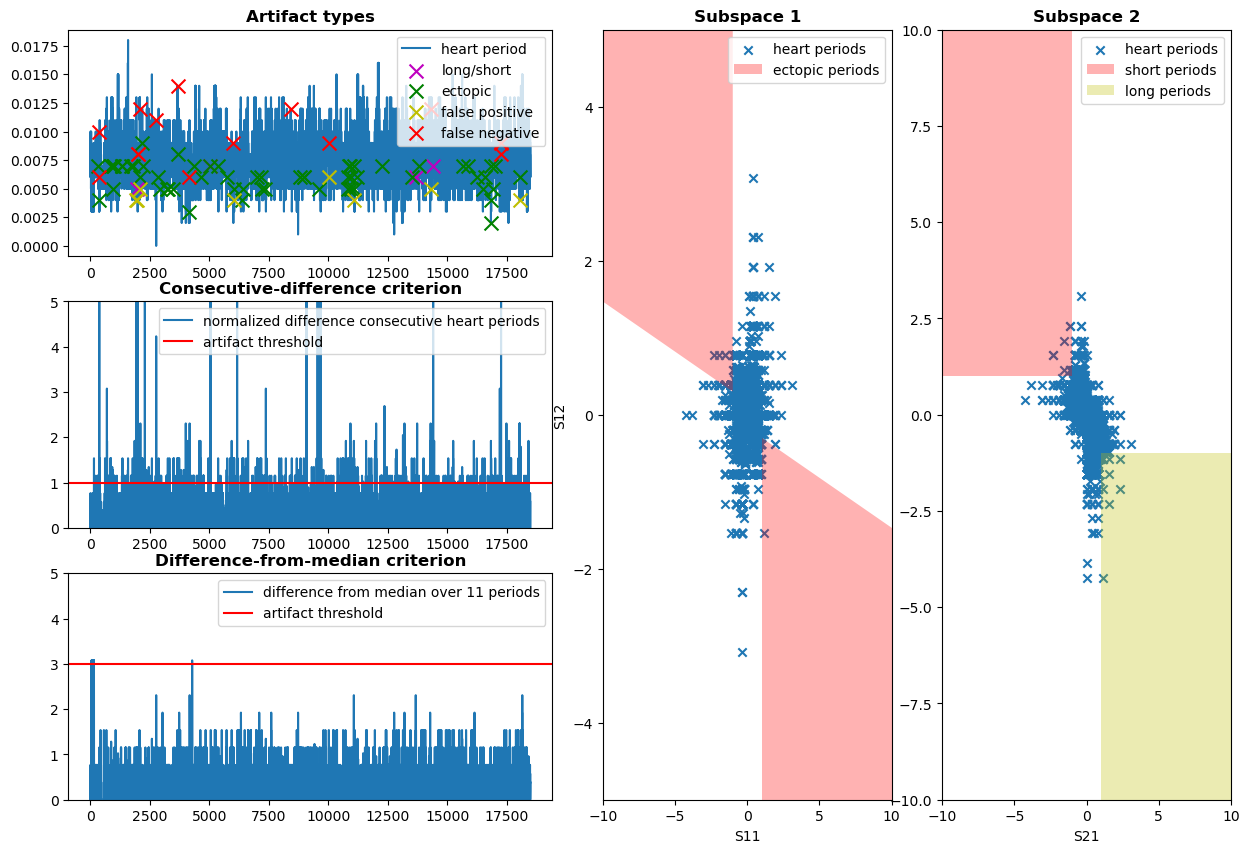

In [14]:
rpeaks_uncorrected  = nk.signal_findpeaks(data)
artifacts, rpeaks_corrected = nk.signal_fixpeaks(rpeaks_uncorrected, iterative=True, show=True)

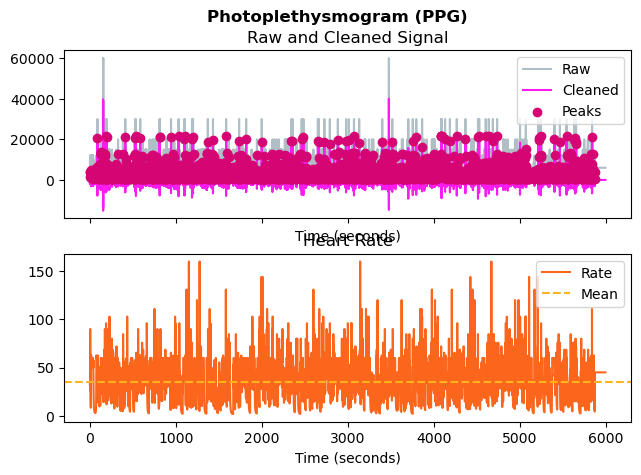

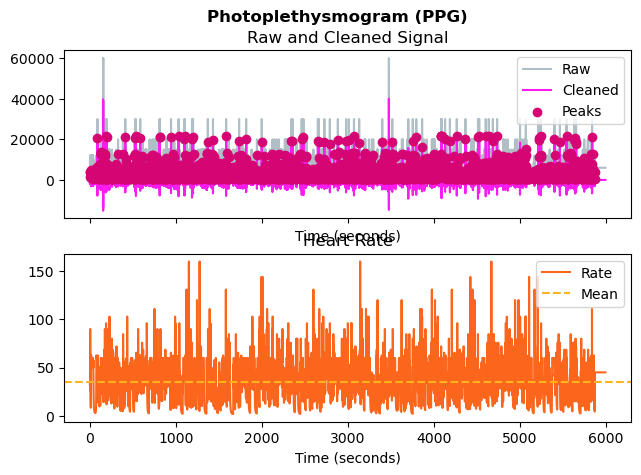

In [15]:
signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals, sampling_rate=24)

In [16]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN  HRV_SDANN1   HRV_SDNNI1  \
0      35.377609  1822.241183  2310.443502   612.79002  2154.495223   

   HRV_SDANN2  HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0  381.052841  2235.27582  278.185592  2286.994476  3187.360155  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.527187    5.256634     0.570462  0.318334   0.821146    0.683984   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.389251  1.957202  2.480685  0.788276  

[1 rows x 90 columns]


Still not accurate. I will try using a different package for the ppg processing and see if that works

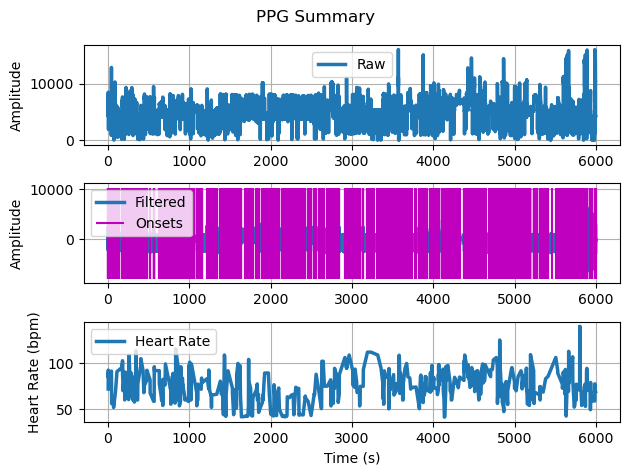

Median HR: 72.35064935064935 bpm


In [17]:
from biosppy.signals import ppg 
data = Group1[0]['DATA']
data = ppg.ppg(signal=data, sampling_rate=24.0, show=True)
median_hr = np.median(data[4])
print("Median HR: "+ str(median_hr) + " bpm")

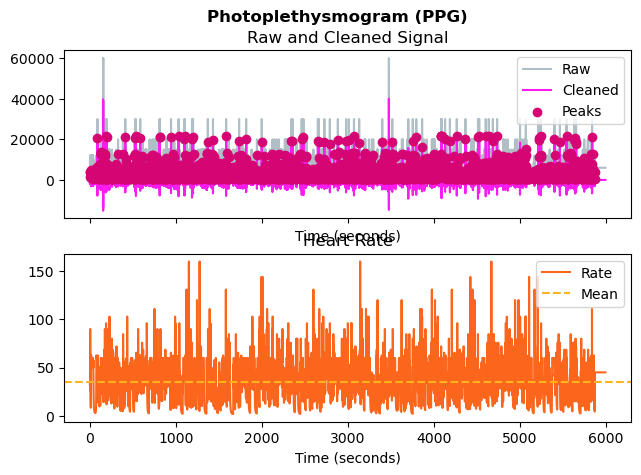

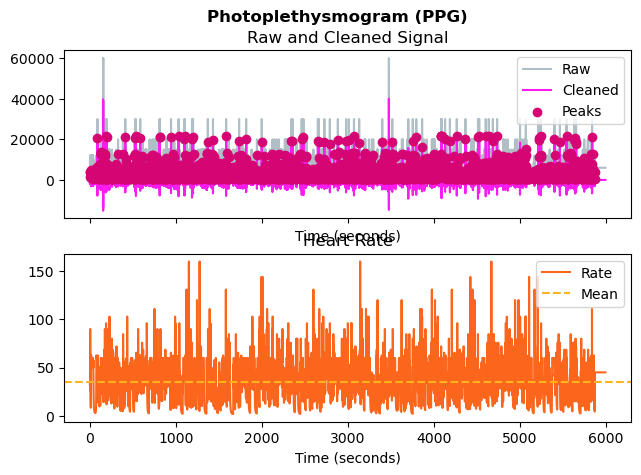

In [18]:
data = data[1]

signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals, sampling_rate=24)

In [19]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN  HRV_SDANN1   HRV_SDNNI1  \
0      35.377609  1822.241183  2310.443502   612.79002  2154.495223   

   HRV_SDANN2  HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0  381.052841  2235.27582  278.185592  2286.994476  3187.360155  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.527187    5.256634     0.570462  0.318334   0.821146    0.683984   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.389251  1.957202  2.480685  0.788276  

[1 rows x 90 columns]


well thats not ideal... lets build our own process function based on biosppy sinmce it gives a realistic Median HR

In [34]:
def match_interpolate_hr(time,hr_time,hr):
    inter_hr = np.nan*np.ones(len(time)) # initialize interpolated hr array
    
    for i in range(len(hr_time)):
        j = hr_time[i]
        # find index of time that is closest in time to i
        idx = np.argmin(np.abs(time-j))
        inter_hr[int(idx)] = hr[i]
    
    # interpolate missing values

    inter_hr = pd.DataFrame(columns=['hr'], data=inter_hr)
    if pd.isnull(inter_hr['hr'][0]):
        inter_hr['hr'][0] = hr[0]
    inter_hr = inter_hr.interpolate(method='linear')
    inter_hr = inter_hr.values.flatten()
    return inter_hr


def custom_process(data, sample_rate=24):
    clean_data = ppg.ppg(signal=data, sampling_rate=sample_rate, show=False)
    
    raw = data.values
    clean_sig = clean_data[1]
    time = clean_data[0]
    
    
    
    heart_rate = clean_data[4]
    heart_rate_ts = clean_data[3]
    
    hr = match_interpolate_hr(time,heart_rate_ts,heart_rate)
    quality = nk.ecg_quality(clean_sig, sampling_rate=sample_rate)

    # find ppg_peaks by making np array of zeros of length of clean_sig and then set 1 to the values of clean_data[2]
    ppg_peaks = np.zeros(len(clean_sig))
    ppg_peaks[clean_data[2]] = 1
    
    signals = pd.DataFrame({"PPG_Raw": np.array(raw),
                            "PPG_Clean": np.array(clean_sig),
                            "PPG_Peaks": ppg_peaks,
                            "PPG_Rate": np.array(hr),
                            "PPG_Quality": quality})
    
    return signals


signals = custom_process(Group1[0]['DATA'], sample_rate=24)


    


In [36]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

/opt/homebrew/Caskroom/miniforge/base/envs/ArtHeart/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN   HRV_SDANN1   HRV_SDNNI1  \
0      76.466602  4325.006013  7785.378989  6034.675212  8390.138289   

    HRV_SDANN2   HRV_SDNNI2   HRV_SDANN5   HRV_SDNNI5     HRV_RMSSD  ...  \
0  3926.729133  8381.471113  1203.751208  7943.743656  11141.591535  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.600202    6.423777     0.667241  0.640131   0.803744    0.639847   

     HRV_CD   HRV_HFD   HRV_KFD  HRV_LZC  
0  0.499482  2.001408  2.939436  0.76807  

[1 rows x 90 columns]


Bit Bodged but it has more realistic HR values. I will try to use this on the whole dataset and see if it works with ML